# Classification

In [131]:
import pandas as pd
import re
import random
import pickle
import numpy as np
from textblob import TextBlob, classifiers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, ShuffleSplit
from matplotlib import pyplot as plt

import nltk
_ = nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/dev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('IMDB Dataset.csv')

In [89]:
# temp
# df = df.sample(1000)

## Cleaning

In [4]:
def clean(txt):
#     print(txt)
    txt = txt.replace('<br />'," ") # replace new line with space
    txt = re.sub(r'^https?:\/\/.*[\r\n]*', '', txt, flags=re.MULTILINE) # remove hyperlinks
    txt = txt.replace('--',"-") # replace double hyphen with single one
    txt = re.sub(r'[*&^#@_~]',' ',txt) # replace any of these characters with space
    txt = re.sub(r'\s+',' ',txt) # replace multiple spaces with single
    return txt.strip()

df['review_clean'] = df['review'].apply(clean)

## Synthetic upsampling of the neg scores

In [5]:
df.groupby('sentiment').count()

,review,review_clean
sentiment,,
negative,2502,2502
positive,25000,25000


In [6]:
_cnt = df.groupby('sentiment').count()[['review']].reset_index().pivot(columns='sentiment',values='review').max()
extra_neg = int(_cnt['positive']-_cnt['negative'])
print(f"Need to synthesize extra {extra_neg} negative samples!")

Need to synthesize extra 22498 negative samples!


In [7]:
neg_samples_orig = df[df.sentiment=='negative']['review_clean'].to_list()

In [8]:
# create new samples by randomly selecting sentences from two reviews
new_samples = []
while len(new_samples) < extra_neg:
    R1 = random.choice(neg_samples_orig)
    R2 = random.choice(neg_samples_orig)
    if R1==R2:
        continue
    #print("R1",R1)
    #print("R2",R2)
    sents = nltk.sent_tokenize(R1)+nltk.sent_tokenize(R2) # all sentences
    random.shuffle(sents)
    R_new = ' '.join(sents[:len(sents)//2]) # take an average amount of sentences
    #print("Rnew",R_new)
    new_samples.append(R_new)

In [9]:
df_new = pd.DataFrame({'review_clean':new_samples,'sentiment':'negative'})
df = df.append(df_new).reset_index().set_index('index')
df.groupby('sentiment').count()

,review,review_clean
sentiment,,
negative,2502,25000
positive,25000,25000


## Create meta features and test them

In [10]:
df['n_chars'] = df['review_clean'].apply(lambda s: len(s)) # review length

In [11]:
df=df[df.n_chars>0]

In [12]:
df['n_excl'] = df['review_clean'].apply(lambda s: len([s_ for s_ in s if s_=='!'])/float(len(s))) # percentage of "!"

In [13]:
df['n_upper'] = df['review_clean'].apply(lambda s: len([s_ for s_ in s if s_.isupper()])/float(len(s))) # pct of upper-c.

In [14]:
df.groupby('sentiment').mean()

,n_chars,n_excl,n_upper
sentiment,,,
negative,342.581240,0.001711,0.03052
positive,1302.272171,0.001046,0.02870


Comment: the first two features can be helpful. :) Positive reviews tend to be longer with higher % of "!".

## Use TextBlob to create linguistic features

In [15]:
n_neg = [] # number of negations, e.g. no, not
n_rev = [] # number of reversed adjectives, e.g. imbalanced, unacceptable
polarity = [] # blob's polarity
conj = [] # blob's polarity*subjectivity

def use_blob(txt):
    blob = TextBlob(txt)
    N = len(blob.words)
    polarity.append(blob.sentiment[0])
    conj.append(blob.sentiment[0]*blob.sentiment[1])
    
    neg,rev = 0,0
    for word in blob.words:
        if word.lower() in ["no", "not", "none", "n't"]:
            neg += 1
        elif word.lower().startswith(("in","im","un")) and len(word)>4:
            rev += 1
    
    n_neg.append(neg/N)
    n_rev.append(rev/N)

_ = df['review_clean'].apply(use_blob) # iterate over all rows

df['n_neg'] = n_neg
df['n_rev'] = n_rev
df['polarity'] = polarity
df['conj'] = conj

In [16]:
df.groupby('sentiment').mean()

,n_chars,n_excl,n_upper,n_neg,n_rev,polarity,conj
sentiment,,,,,,,
negative,342.581240,0.001711,0.03052,0.018671,0.010983,-0.037060,-0.027244
positive,1302.272171,0.001046,0.02870,0.011389,0.011670,0.195297,0.107556


Comment: all new features provide some edge.

In [3]:
# df.to_csv('data_cleaned.csv')
df=pd.read_csv('data_cleaned.csv')

## Dataset split

In [97]:
features = [
    'n_chars',
    'n_excl',
    'n_neg',
    'n_rev',
    'polarity',
    'conj'
]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df[features+['review_clean']].values, 
                                                  df['sentiment'].values, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=df['sentiment'].values)

In [6]:
df[features].corr()

,n_chars,n_excl,n_neg,n_rev,polarity,conj
n_chars,1.000000,-0.082989,-0.157986,0.072420,0.217085,0.193456
n_excl,-0.082989,1.000000,0.026445,-0.023853,-0.016691,-0.012215
n_neg,-0.157986,0.026445,1.000000,-0.053549,-0.158297,-0.148088
n_rev,0.072420,-0.023853,-0.053549,1.000000,-0.007526,-0.010362
polarity,0.217085,-0.016691,-0.158297,-0.007526,1.000000,0.974368
conj,0.193456,-0.012215,-0.148088,-0.010362,0.974368,1.000000


Comment: most of the features is not highly correlated, except conj.

## Intermediate (NaiveBayes) classification of vocabulary

In [25]:
# temp
NB_training = []
for sentiment, review in zip(y_train,X_train[:,-1]):
    NB_training.append((review,sentiment))
    
NB_val = [] # this should be validation.. 
for sentiment, review in zip(y_val,X_val[:,-1]):
    NB_val.append((review,sentiment))

In [9]:
clf_NB = classifiers.NaiveBayesClassifier(NB_training[:2000])
# file = open('clf_NB.pickle','wb')
# pickle.dump(clf_NB,file)

In [35]:
# i=1000
# while i<len(NB_training):
#     print(f"updating... {i}/{len(NB_training)}")
#     clf_NB.update(NB_training[i:(i+1000)])
    
#     # save classifier

#     file = open('clf_NB.pickle','wb')
#     pickle.dump(clf_NB,file)
#     i += 1000

In [27]:
clf_NB.accuracy(NB_val[:1000])

0.881

In [36]:
clf_NB.show_informative_features(10)

Most Informative Features
        contains(behind) = True           positi : negati =     37.2 : 1.0
       contains(created) = True           positi : negati =     34.1 : 1.0
     contains(impressed) = True           positi : negati =     32.8 : 1.0
       contains(society) = True           positi : negati =     32.8 : 1.0
        contains(normal) = True           positi : negati =     30.2 : 1.0
          contains(rare) = True           positi : negati =     30.2 : 1.0
        contains(superb) = True           positi : negati =     30.0 : 1.0
      contains(episodes) = True           positi : negati =     28.8 : 1.0
         contains(helps) = True           positi : negati =     28.8 : 1.0
             contains() = True           positi : negati =     28.8 : 1.0


### Create new feature from intermediate classification

In [42]:
NB_prob_train = []
for i,txt in enumerate(X_train[:,-1]):
    if i%1000==0:
        print(f"classifying {i}")
    NB_prob_train.append(round(clf_NB.prob_classify(txt).prob('positive'),3))

classifying 0
classifying 1000
classifying 2000
classifying 3000
classifying 4000
classifying 5000
classifying 6000
classifying 7000
classifying 8000
classifying 9000
classifying 10000
classifying 11000
classifying 12000
classifying 13000
classifying 14000
classifying 15000
classifying 16000
classifying 17000
classifying 18000
classifying 19000
classifying 20000
classifying 21000
classifying 22000
classifying 23000
classifying 24000
classifying 25000
classifying 26000
classifying 27000
classifying 28000
classifying 29000
classifying 30000
classifying 31000
classifying 32000
classifying 33000
classifying 34000
classifying 35000
classifying 36000
classifying 37000
classifying 38000
classifying 39000


[0.0,
 0.0,
 1.0,
 0.411,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.702,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.993,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.476,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.979,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.001,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1

In [52]:
NB_prob_test = []
for i,txt in enumerate(X_test[:,-1]):
    if i%1000==0:
        print(f"classifying {i}")
    NB_prob_test.append(round(clf_NB.prob_classify(txt).prob('positive'),3))
    
np.array(NB_prob_test).dump('NB_prob_test.npy')    

classifying 0
classifying 1000
classifying 2000
classifying 3000
classifying 4000
classifying 5000
classifying 6000
classifying 7000
classifying 8000
classifying 9000


## Final model selection

In [53]:
X_final = X_train
X_final[:,-1] = NB_prob_train # add the last feature / vocab

In [54]:
Xf_train, Xf_val, yf_train, yf_val = train_test_split(X_final, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y_train)

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [84]:
CLFs = {
        "Decision Tree":DecisionTreeClassifier(max_depth=5),
        "Linear SVC":SVC(kernel="linear", C=0.025),
        "Nonlinear SVC":SVC(gamma=2, C=1),
        "Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        "MLP":MLPClassifier(alpha=1, max_iter=1000),
        "AdaBoost":AdaBoostClassifier(),
        }

In [85]:
for name,clf in CLFs.items():
    clf.fit(Xf_train,yf_train)
    y_pred = clf.predict(Xf_val)
    print(f"{name} accuracy: {round(accuracy_score(yf_val, y_pred),3)}, F1 {round(f1_score([mapper[y_] for y_ in yf_val],[mapper[y_] for y_ in y_pred]),3)}")

Decision Tree accuracy: 0.936, F1 0.934
Linear SVC accuracy: 0.936, F1 0.934
Nonlinear SVC accuracy: 0.927, F1 0.924
Random Forest accuracy: 0.933, F1 0.929
MLP accuracy: 0.933, F1 0.929
AdaBoost accuracy: 0.936, F1 0.935


Not surprisingly, AdaBoost is the best so far, let's tune its hyperparameters now.

### Hyperparameter tuning

In [90]:
ada_result = []
for n_est in [10,20,50,100,200]:
    for lr in [0.1, 0.2, 0.4, 0.8, 2.0]:
        print(f"training {n_est} / {lr}...",end="")
        clf = AdaBoostClassifier(n_estimators=n_est, learning_rate=lr)
        clf.fit(Xf_train,yf_train)
        s=clf.score(Xf_train,yf_train)
        print(s)
        ada_result.append((n_est,lr,s))

training 10 / 0.1...0.924153879808744
training 10 / 0.2...0.9262164442638833
training 10 / 0.4...0.9316541141910685
training 10 / 0.8...0.9348104628269633
training 10 / 2.0...0.9216538016813025
training 20 / 0.1...0.9263726991468484
training 20 / 0.2...0.9288727772742899
training 20 / 0.4...0.9373105409544048
training 20 / 0.8...0.9378730585330791
training 20 / 2.0...0.9216538016813025
training 50 / 0.1...0.9314666083315104
training 50 / 0.2...0.9386855839244976
training 50 / 0.4...0.9394981093159162
training 50 / 0.8...0.9389668427138348
training 50 / 2.0...0.9216538016813025
training 100 / 0.1...0.9396231132222882
training 100 / 0.2...0.9401856308009625
training 100 / 0.4...0.9401543798243696
training 100 / 0.8...0.9396231132222882
training 100 / 2.0...0.9216538016813025
training 200 / 0.1...0.9401856308009625
training 200 / 0.2...0.9405293915434857
training 200 / 0.4...0.9404043876371136
training 200 / 0.8...0.9402481327541485
training 200 / 2.0...0.9216538016813025


In [92]:
opt_params = sorted(ada_result,key=lambda x: x[2])[-1]
print(f"Optimum accuracy, {opt_params[2]}, obtained for: {opt_params[:2]}")

Optimum accuracy, 0.9405293915434857, obtained for: (200, 0.2)


In [116]:
clf_final = AdaBoostClassifier(n_estimators=opt_params[0], learning_rate=opt_params[1])
clf_final.fit(X_final[:,:],y_train)

AdaBoostClassifier(learning_rate=0.2, n_estimators=200)

### Learning curve

In [134]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

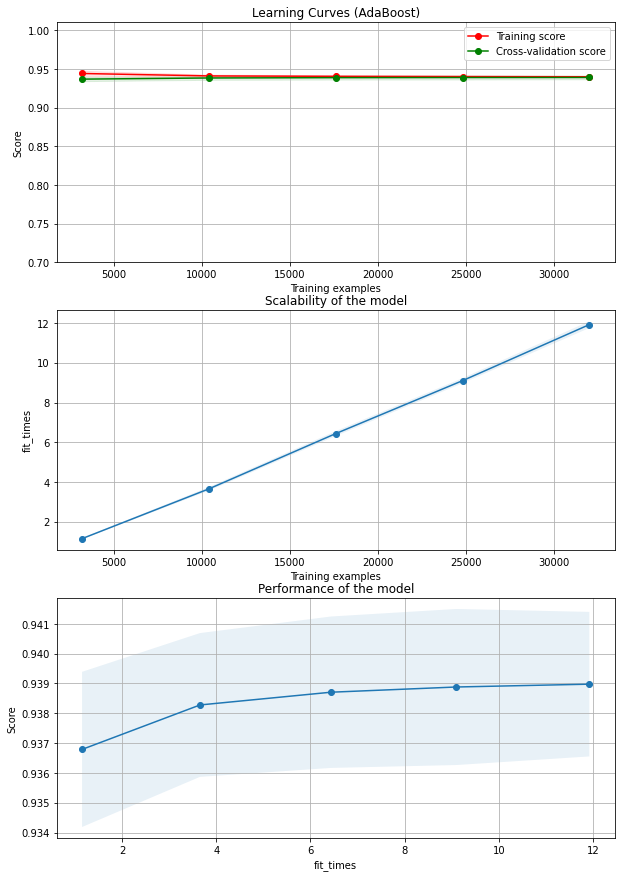

In [135]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15)) 
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = AdaBoostClassifier(n_estimators=opt_params[0], learning_rate=opt_params[1])

plot_learning_curve(estimator, "Learning Curves (AdaBoost)", X_final[:,:], y_train, axes=axes, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

## Feature importance

<BarContainer object of 7 artists>

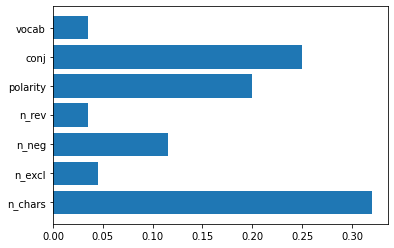

In [117]:
plt.barh(features+['vocab'], clf_final.feature_importances_)

It seems the most important features are the review length, amount of negations and the average sentiment.

## Final evaluation on the test dataset

In [118]:
Xf_test = X_test
Xf_test[:,-1] = NB_prob_test # add the last feature / vocab
y_pred = clf_final.predict(Xf_test[:,:])

In [126]:
y_true_, y_pred_ = [mapper[y_] for y_ in y_test],[mapper[y_] for y_ in y_pred]

final_accuracy = round(accuracy_score(y_test, y_pred),3)
final_f1 = round(f1_score(y_true_, y_pred_),3)
final_precision = round(precision_score(y_true_, y_pred_),3)
final_recall = round(recall_score(y_true_, y_pred_),3)
final_cm = confusion_matrix(y_test, y_pred)

In [125]:
print("Accuracy:",final_accuracy)
print("F1:",final_f1)
print("Precision:",final_precision)
print("Recall:",final_recall)

Accuracy: 0.94
F1: 0.938
Precision: 0.968
Recall: 0.909


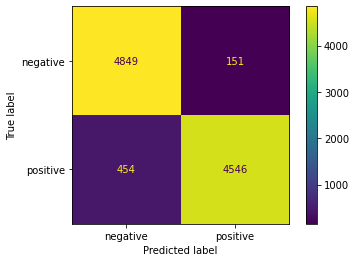

In [130]:
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm,
                              display_labels=clf_final.classes_)
disp.plot()

In [138]:
"vocab only", f1_score(y_true_, np.round(NB_prob_test,0)) 

('vocab only', 0.8520261738032373)